In [1]:
!pip install ydata_profiling
!pip install openpyxl
!pip install umap-learn

In [128]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from ydata_profiling import ProfileReport
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import skew
from sklearn.decomposition import TruncatedSVD
import joblib
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

# Load the datasets

In [3]:
# Update these paths to match your local environment or the environment in which your notebook runs.
azdias = pd.read_csv('arvato_data/data//Udacity_AZDIAS_052018.csv', sep=';', dtype='category')
customers = pd.read_csv('arvato_data/data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype='category')
print("AZDIAS shape:", azdias.shape)
print("CUSTOMERS shape:", customers.shape)

AZDIAS shape: (891221, 366)
CUSTOMERS shape: (191652, 369)


It will be benificial to perform data correction on both datasets at once so we will join the two columns together and seperate them again later

In [4]:
azdias['dataset_type'] = 'general_population'
customers['dataset_type'] = 'customer'
ac_data = pd.concat([azdias, customers], axis=0, ignore_index=True)
print(f"Combined dataset shape: {ac_data.shape}")
print(ac_data['dataset_type'].value_counts())

Combined dataset shape: (1082873, 370)
dataset_type
general_population    891221
customer              191652
Name: count, dtype: int64


convert all objects to categories to reduce memory consumption.  Categories store each unique category only once, with integer codes referencing these categories. This dramatically reduces memory usage for columns with many repeated values.

In [5]:
obj_columns = ac_data.select_dtypes(['object']).columns
obj_columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB', 'dataset_type', 'PRODUCT_GROUP',
       'CUSTOMER_GROUP', 'ONLINE_PURCHASE'],
      dtype='object', length=370)

In [6]:
ac_data[obj_columns] = ac_data[obj_columns].astype('category')

# Initial Data Inspection

In [7]:
display(ac_data.head())

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,dataset_type,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3,1,2,general_population,NaN,NaN,NaN
1,910220,-1,9,0,NaN,NaN,NaN,NaN,21,11,...,3,9,4,5,2,1,general_population,NaN,NaN,NaN
2,910225,-1,9,17,NaN,NaN,NaN,NaN,17,10,...,3,9,2,5,2,3,general_population,NaN,NaN,NaN
3,910226,2,1,13,NaN,NaN,NaN,NaN,13,1,...,NaN,9,7,3,2,4,general_population,NaN,NaN,NaN
4,910241,-1,1,20,NaN,NaN,NaN,NaN,14,3,...,2,9,3,4,1,3,general_population,NaN,NaN,NaN


# Correcting data

## Replace unknown values with NaN

In [8]:
attribute_desc_path = 'arvato_data/data/DIAS Attributes - Values 2017.xlsx'
attribute_desc_df = pd.read_excel(attribute_desc_path)
print("Attribute Description DataFrame:")
print(attribute_desc_df.head(10))

Attribute Description DataFrame:
              Attribute                                   Description  Value  \
0              AGER_TYP                            best-ager typology     -1   
1                   NaN                                           NaN      0   
2                   NaN                                           NaN      1   
3                   NaN                                           NaN      2   
4                   NaN                                           NaN      3   
5  ALTERSKATEGORIE_GROB  age classification through prename analysis   -1, 0   
6                   NaN                                           NaN      1   
7                   NaN                                           NaN      2   
8                   NaN                                           NaN      3   
9                   NaN                                           NaN      4   

                      Meaning  
0                     unknown  
1  no classification p

In [9]:
def get_unknown_values(attribute_desc_df, meaning_keywords=['unknown']):
    """
    Extracts a dictionary mapping each attribute to its 'unknown' values based on meaning keywords.

    Parameters:
    - attribute_desc_df (pd.DataFrame): DataFrame containing attribute descriptions.
    - meaning_keywords (list of str): Keywords indicating an 'unknown' meaning.

    Returns:
    - dict: Dictionary with attribute names as keys and lists of 'unknown' values as values.
    """
    unknown_values_dict = {}
    
    # Ensure 'Meaning' column is string type for safe string operations
    attribute_desc_df['Meaning'] = attribute_desc_df['Meaning'].astype(str)
    
    # Iterate over each attribute
    for attr in attribute_desc_df['Attribute'].unique():
        attr_rows = attribute_desc_df[attribute_desc_df['Attribute'] == attr]
        
        # Identify rows where 'Meaning' contains any of the given keywords (case-insensitive)
        mask = attr_rows['Meaning'].str.contains('|'.join(meaning_keywords), case=False, na=False)
        unknown_rows = attr_rows[mask]
        
        if not unknown_rows.empty:
            # Collect all unknown values for this attribute
            all_unknown_values = []
            for val in unknown_rows['Value'].dropna().unique():
                # Split by comma in case multiple unknown values are listed
                split_vals = [v.strip() for v in str(val).split(',')]
                
                # Attempt to convert each split value to int or float
                processed_values = []
                for v in split_vals:
                    try:
                        # Try float first to handle cases like '0.0' if any
                        # if '.' in v:
                        processed_values.append(v)
                        # else:
                        #     processed_values.append(int(v))
                    except ValueError:
                        # If conversion fails, keep as string
                        processed_values.append(v)
                
                all_unknown_values.extend(processed_values)

            # Store the list of unknown values for this attribute
            unknown_values_dict[attr] = list(set(all_unknown_values))  # use set to remove duplicates if needed

    return unknown_values_dict


In [10]:
unknown_values_dict = get_unknown_values(attribute_desc_df)

In [11]:
print(ac_data.isna().sum().sum())

50031108


In [12]:
for col, unknown_values in unknown_values_dict.items():
    if col in ac_data.columns:
        ac_data[col] = ac_data[col].replace(unknown_values, np.nan)

/tmp/ipykernel_28625/3593124255.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ac_data[col] = ac_data[col].replace(unknown_values, np.nan)


In [13]:
print(ac_data.isna().sum().sum())

54233742


## Numeric datatype

In [14]:
def get_numeric_columns(attribute_desc_df, numeric_keywords=['numeric value']):
    """
    Extracts a list of attributes that are described as numeric based on keywords in their descriptions.

    Parameters:
    - attribute_desc_df (pd.DataFrame): DataFrame containing attribute descriptions.
    - numeric_keywords (list of str): Keywords indicating a numeric value.

    Returns:
    - list: List of attribute names marked as numeric.
    """
    numeric_columns = []
    attribute_desc_df['Description'] = attribute_desc_df['Description'].astype(str)
    
    for attr in attribute_desc_df['Attribute'].unique():
        attr_rows = attribute_desc_df[attribute_desc_df['Attribute'] == attr]
        mask = attr_rows['Meaning'].str.contains('|'.join(numeric_keywords), case=False, na=False)
        if mask.any():
            numeric_columns.append(attr)
    
    return numeric_columns

numeric_columns = get_numeric_columns(attribute_desc_df)
print("\nNumeric Columns:")
print(numeric_columns)


Numeric Columns:
['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']


In [15]:
# Function to convert specified columns to numeric
def convert_to_numeric(df, numeric_columns):
    """
    Converts specified columns in a DataFrame to numeric, coercing errors to NaN.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to process.
    - numeric_columns (list): List of column names to convert to numeric.
    
    Returns:
    - pd.DataFrame: The updated DataFrame.
    """
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('float32')

        else:
            print(f"Column '{col}' not found in DataFrame.")
    return df
    
ac_data = convert_to_numeric(ac_data, numeric_columns)
print("\nNumeric column data types:")
print(ac_data[numeric_columns].dtypes)


Numeric column data types:
ANZ_HAUSHALTE_AKTIV    float32
ANZ_HH_TITEL           float32
ANZ_PERSONEN           float32
ANZ_TITEL              float32
GEBURTSJAHR            float32
KBA13_ANZAHL_PKW       float32
MIN_GEBAEUDEJAHR       float32
dtype: object


## Binary datatype

In [16]:
binary_cols = []
for col in ac_data.columns:
    n_unique = ac_data[col].dropna().nunique()
    if n_unique == 2:
        binary_cols.append(col)
binary_cols  

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KBA05_SEG6',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP',
 'ANREDE_KZ',
 'dataset_type',
 'CUSTOMER_GROUP',
 'ONLINE_PURCHASE']

Set these columns to category to prevent a numerical processing of these features

In [17]:
ac_data[binary_cols] = ac_data[binary_cols].astype('category')

# Remove/Transform Features

LNR is a unique identifier.  EINGEFUEGT_AM is a date item.  we could chunk it and classify it into chunks, but for this project we will simply drop it to save on time.

In [18]:
columns_to_drop = ['LNR']

## Binning birth year

In [19]:
ac_data['GEBURTSJAHR'] = ac_data['GEBURTSJAHR'].replace(0.0, np.nan)
ac_data['GEBURTSJAHR']

0             NaN
1          1996.0
2          1979.0
3          1957.0
4          1963.0
            ...  
1082868       NaN
1082869       NaN
1082870    1944.0
1082871       NaN
1082872    1937.0
Name: GEBURTSJAHR, Length: 1082873, dtype: float32

In [20]:
# Ensure GEBURTSJAHR is numeric
ac_data['GEBURTSJAHR'] = pd.to_numeric(ac_data['GEBURTSJAHR'], errors='coerce')

In [21]:
# Define bins for 10-year intervals from 1900 to 2020, stepping by 10 years
bins = range(1900, 2021, 10)
labels = [f"{start}-{start+9}" for start in bins[:-1]]
ac_data['GEBURTSJAHR_BINNED'] = pd.cut(
    ac_data['GEBURTSJAHR'], 
    bins=bins, 
    labels=labels, 
    right=False  # Include the left bin edge, exclude the right
)
binned_counts = ac_data['GEBURTSJAHR_BINNED'].value_counts().sort_index()
print(binned_counts)

GEBURTSJAHR_BINNED
1900-1909        49
1910-1919       822
1920-1929     13261
1930-1939     47471
1940-1949     79498
1950-1959     97116
1960-1969    121191
1970-1979     98985
1980-1989     87956
1990-1999     40989
2000-2009      6602
2010-2019      3591
Name: count, dtype: int64


In [22]:
ac_data['GEBURTSJAHR_BINNED'] = ac_data['GEBURTSJAHR_BINNED'].astype('category')

In [23]:
ac_data = ac_data.drop(columns=['GEBURTSJAHR'])

In [24]:
numeric_columns.remove("GEBURTSJAHR")

## Date columns

EINGEFUEGT_AM is a date column so we will process it into smaller columns and drop it

In [25]:
ac_data['EINGEFUEGT_AM'] = pd.to_datetime(ac_data['EINGEFUEGT_AM'], errors='coerce')

years = ac_data['EINGEFUEGT_AM'].dt.year
ac_data['Month'] = ac_data['EINGEFUEGT_AM'].dt.month

min_year = years.min()
max_year = years.max()

# Create bins for every 5 years
bins = range(int(min_year), int(max_year + 6), 5)  # step of 5
ac_data['Year_5yr_Bin'] = pd.cut(years, bins=bins, right=False)

In [26]:
# Extract the intervals from the category
intervals = ac_data['Year_5yr_Bin'].cat.categories
interval_labels = [f"[{int(interval.left)}, {int(interval.right)})" for interval in intervals]
print(interval_labels)
ac_data['Year_5yr_Bin'] = ac_data['Year_5yr_Bin'].cat.rename_categories(interval_labels)

['[1991, 1996)', '[1996, 2001)', '[2001, 2006)', '[2006, 2011)', '[2011, 2016)', '[2016, 2021)']


In [28]:
ac_data['Year_5yr_Bin'] = ac_data['Year_5yr_Bin'].astype('category')
ac_data['Month'] = ac_data['Month'].astype('category')

In [29]:
columns_to_drop.append('EINGEFUEGT_AM')

In [30]:
ac_data = ac_data.drop(columns=columns_to_drop)

## Reduce Scewing in Numerical distributions

In [31]:
numeric_data = ac_data[numeric_columns]

In [32]:
numeric_data

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
0,NaN,NaN,NaN,NaN,NaN,NaN
1,11.0,0.0,2.0,0.0,963.0,1992.0
2,10.0,0.0,1.0,0.0,712.0,1992.0
3,1.0,0.0,0.0,0.0,596.0,1997.0
4,3.0,0.0,4.0,0.0,435.0,1992.0
...,...,...,...,...,...,...
1082868,1.0,0.0,1.0,0.0,646.0,1992.0
1082869,0.0,NaN,0.0,0.0,1600.0,1997.0
1082870,1.0,0.0,3.0,0.0,642.0,1992.0
1082871,4.0,0.0,4.0,0.0,254.0,1992.0


### Normalize and scale the data

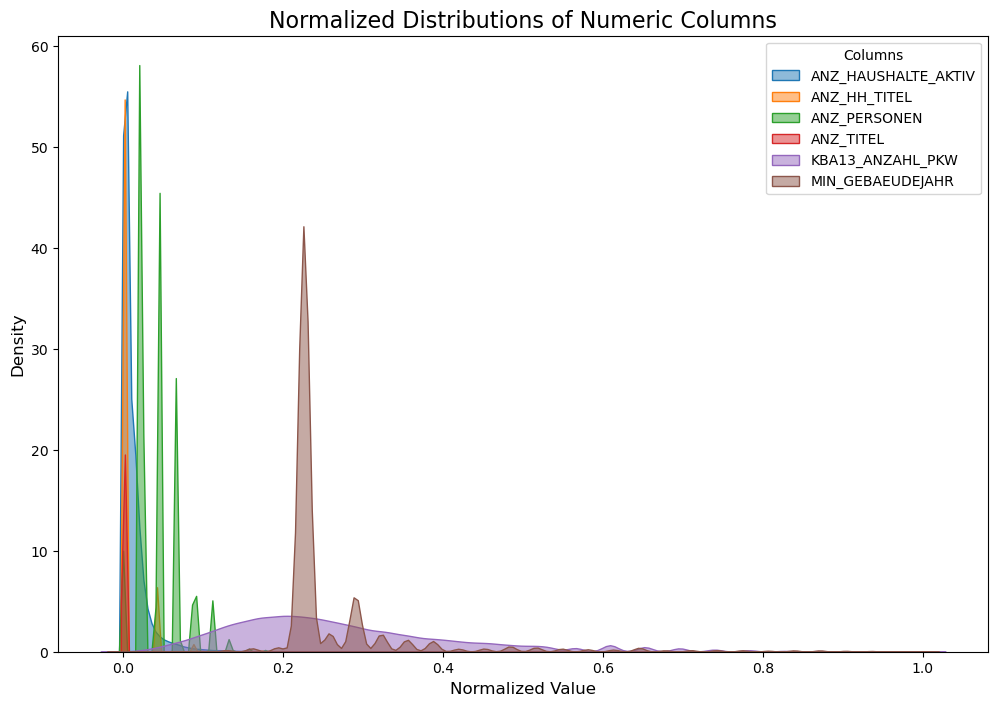

In [33]:
normalized_data = (numeric_data - numeric_data.min()) / (numeric_data.max() - numeric_data.min())

# Plot the distributions
plt.figure(figsize=(12, 8))
for column in normalized_data.columns:
    # Plot the histogram of each column
    sns.kdeplot(normalized_data[column], label=column, fill=True, alpha=0.5)

plt.title('Normalized Distributions of Numeric Columns', fontsize=16)
plt.xlabel('Normalized Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Columns')
plt.show()

It seems obvious that many of the distributions are scewed, but lets do a numerical calcualtion

In [34]:
# Calculate skewness for each column
skewness_values = azdias[numeric_columns].skew()
print("Skewness of each column:")
print(skewness_values)

# Identify columns with high skewness (e.g., skewness > 1 or < -1)
high_skew_columns = skewness_values[abs(skewness_values) > 1].index.tolist()
print("Columns with high skewness:", high_skew_columns)

Skewness of each column:
ANZ_HAUSHALTE_AKTIV     8.779952
ANZ_HH_TITEL           22.718694
ANZ_PERSONEN            1.875265
ANZ_TITEL              18.792796
KBA13_ANZAHL_PKW        1.263094
MIN_GEBAEUDEJAHR        3.556034
dtype: object
Columns with high skewness: ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']


It seems that 6 out of the 6 columns are scewed. We will take a log of the data to try to remove.  We will use the natural logarithm of 1+x, as it is specifically designed for cases where x is close to zero.

In [35]:
for col in high_skew_columns:
    ac_data[col] = np.log1p(ac_data[col])
transformed_skewness = ac_data[numeric_columns].skew()
print("\nSkewness After Log Transformation:")
print(transformed_skewness)


Skewness After Log Transformation:
ANZ_HAUSHALTE_AKTIV     0.811500
ANZ_HH_TITEL            7.281824
ANZ_PERSONEN            0.189940
ANZ_TITEL              13.225435
KBA13_ANZAHL_PKW       -0.648903
MIN_GEBAEUDEJAHR        3.582273
dtype: float32


In [36]:
ac_data['ANZ_TITEL'].value_counts()

ANZ_TITEL
0.000000    956858
0.693147      5503
1.098612       400
1.386294        13
1.609438         2
1.945910         1
1.791759         1
Name: count, dtype: int64

In [37]:
first_freq = ac_data['ANZ_TITEL'].value_counts().iloc[0]
total_items= ac_data['ANZ_TITEL'].notna().sum()
print(first_freq/total_items)

0.9938511266356315


Considering 99% of the data is just one value we will just drop this column

this helped with some of the skewing, but ANZ_TITEL is still highly scewed. lets take a closer look at it

In [38]:
ac_data = ac_data.drop(columns='ANZ_TITEL')

In [39]:
numeric_columns.remove("ANZ_TITEL")

## Dropping missing values

### Column wise

In [40]:
def missing_value_percentage(df, df_name, threshold=0):
    """
    Calculates and prints the percentage of missing values per column in a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - df_name (str): Name of the DataFrame (for display purposes).
    - threshold (float): Minimum percentage threshold to display columns.
    
    Returns:
    - pd.Series: Sorted series of missing value percentages.
    """
    missing_percent = df.isna().mean() * 100  # Calculate percentage
    missing_percent = missing_percent[missing_percent > threshold]  # Filter based on threshold
    missing_percent_sorted = missing_percent.sort_values(ascending=False)
    
    print(f"\nMissing Values in {df_name} (Percentage):")
    print(missing_percent_sorted.to_string())
    
    return missing_percent_sorted

We will use 70% as the cuttof threshold, if there is onl 30% of data for a specific column it can be hard to learn from the features. We probably can use 60% or even 50% as cutoff values, but we will be generious and use a model which can handle NaN values. Ideally you would want to dive deeper into the data and pick an appropriate number after testing and evaluating.

In [41]:
missing_thresh = 70 # in percentage

In [42]:
missing_azdias = missing_value_percentage(ac_data, 'Full dataset', threshold=missing_thresh)


Missing Values in Full dataset (Percentage):
ALTER_KIND4        99.866928
TITEL_KZ           99.587025
ALTER_KIND3        99.312477
ALTER_KIND2        96.804888
ALTER_KIND1        91.427988
CUSTOMER_GROUP     82.301526
PRODUCT_GROUP      82.301526
ONLINE_PURCHASE    82.301526
AGER_TYP           71.071123


In [43]:
print("ac_data shape:", ac_data.shape)

ac_data shape: (1082873, 369)


In [44]:
columns_to_drop = [
    'ALTER_KIND4',
    'TITEL_KZ',
    'ALTER_KIND3',
    'ALTER_KIND2',
    'ALTER_KIND1',
    'CUSTOMER_GROUP',
    'PRODUCT_GROUP',
    'ONLINE_PURCHASE',
    'AGER_TYP'
]
ac_data = ac_data.drop(columns=columns_to_drop)

In [45]:
print("ac_data shape:", ac_data.shape)

ac_data shape: (1082873, 360)


### Row wise

Dropping rows with 70% missing data.  If given more time i would explore into the rows which had 70% or more missing data. Perhaps they don't need to be dropped, or we can learn something form these samples.

In [46]:
missing_per_row = ac_data.isna().sum(axis=1)

In [47]:
threshold = ac_data.shape[1] * 0.7

In [48]:
len(ac_data[missing_per_row <= threshold])/ len(ac_data)

0.8890756349082487

In [49]:
ac_data = ac_data[missing_per_row <= threshold]

# Encode high dimentional features

Generally, when the number of unique categories is high, one-hot encoding becomes impractical as it produces a large number of columns. For these high-cardinality categorical variables, frequency encoding can help reduce the feature space.

In [50]:
cat_columns = ac_data.select_dtypes(['category']).columns
# Count the total number of unique categories across all categorical columns
total_unique_categories = [(col, ac_data[col].nunique()) for col in cat_columns]
# Sort the list by the nunique count in descending order
sorted_unique_categories = sorted(total_unique_categories, key=lambda x: x[1], reverse=True)

In [51]:
cat_columns = ac_data.select_dtypes(['category']).columns
# Count the total number of unique categories across all categorical columns
total_unique_categories = [(col, ac_data[col].nunique()) for col in cat_columns]
# Sort the list by the nunique count in descending order
sorted_unique_categories = sorted(total_unique_categories, key=lambda x: x[1], reverse=True)
for row in sorted_unique_categories:
    name,val = row
    if val > 40:
        print(row)

('ANZ_STATISTISCHE_HAUSHALTE', 269)
('EXTSEL992', 56)
('VERDICHTUNGSRAUM', 46)
('CAMEO_DEU_2015', 45)
('LP_LEBENSPHASE_FEIN', 41)


Lets go ahead and frequency encode ANZ_STATISTISCHE_HAUSHALTE and EXTSEL992.  LNR will be dropped later so we won't deal with it for now.

In [52]:
for col, unique_count in sorted_unique_categories:
    if unique_count > 50:  # Arbitrary threshold; you can adjust
        freq = ac_data[col].value_counts()
        ac_data[col + '_freq'] = ac_data[col].map(freq)
        ac_data = ac_data.drop(columns=[col])

In [53]:
ac_data.columns

Index(['AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN', 'ARBEIT', 'BALLRAUM',
       'CAMEO_DEU_2015',
       ...
       'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ', 'ALTERSKATEGORIE_GROB',
       'dataset_type', 'GEBURTSJAHR_BINNED', 'Month', 'Year_5yr_Bin',
       'ANZ_STATISTISCHE_HAUSHALTE_freq', 'EXTSEL992_freq'],
      dtype='object', length=360)

In [54]:
cat_columns = ac_data.select_dtypes(['category']).columns
# Count the total number of unique categories across all categorical columns
total_unique_categories = [(col, ac_data[col].nunique()) for col in cat_columns]
# Sort the list by the nunique count in descending order
sorted_unique_categories = sorted(total_unique_categories, key=lambda x: x[1], reverse=True)
for row in sorted_unique_categories:
    name,val = row
    if val > 40:
        print(row)

('EXTSEL992_freq', 56)
('VERDICHTUNGSRAUM', 46)
('CAMEO_DEU_2015', 45)
('LP_LEBENSPHASE_FEIN', 41)


# Standardize features and reduce memory footprint

In [55]:
numeric_cols = ac_data.select_dtypes(include=['float64',  'int64', ]).columns.tolist()
print("Numeric Columns:", numeric_cols)

Numeric Columns: ['ANZ_STATISTISCHE_HAUSHALTE_freq']


In [56]:
num64_cols = ac_data.select_dtypes(include=['int64', 'float64']).columns
num64_cols

Index(['ANZ_STATISTISCHE_HAUSHALTE_freq'], dtype='object')

In [57]:
ac_data[num64_cols] = ac_data[num64_cols].astype('float32')

In [58]:
numeric_cols = ac_data.select_dtypes(include=['float32', 'int32']).columns.tolist()

In [59]:
numeric_cols

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR',
 'ANZ_STATISTISCHE_HAUSHALTE_freq']

In [60]:
ac_data[numeric_cols].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,ANZ_STATISTISCHE_HAUSHALTE_freq
count,939798.000000,933755.000000,962756.000000,925792.000000,939798.000000,939798.000
mean,1.636076,0.025709,0.951956,6.296192,7.598018,133093.125
std,0.924178,0.151008,0.396845,0.565271,0.001648,118218.125
min,0.000000,0.000000,0.000000,0.000000,7.593878,1.000
25%,0.693147,0.000000,0.693147,5.968708,7.597396,35598.000
50%,1.386294,0.000000,0.693147,6.322565,7.597396,68803.000
75%,2.302585,0.000000,1.098612,6.668228,7.597898,296670.000
max,6.390241,3.178054,3.828641,7.741099,7.609366,296670.000


In [61]:
data_scaler = StandardScaler()
ac_data[numeric_cols] = data_scaler.fit_transform(ac_data[numeric_cols])

In [62]:
ac_data[numeric_cols].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,ANZ_STATISTISCHE_HAUSHALTE_freq
count,9.397980e+05,9.337550e+05,9.627560e+05,9.257920e+05,9.397980e+05,9.397980e+05
mean,8.832516e-09,1.509938e-08,1.394718e-08,-2.241535e-09,1.980822e-08,-5.195598e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.770305e+00,-1.702522e-01,-2.398812e+00,-1.113836e+01,-2.512345e+00,-1.125819e+00
25%,-1.020290e+00,-1.702522e-01,-6.521664e-01,-5.793420e-01,-3.776589e-01,-8.247057e-01
50%,-2.702752e-01,-1.702522e-01,-6.521664e-01,4.665421e-02,-3.776589e-01,-5.438265e-01
75%,7.211907e-01,-1.702522e-01,3.695558e-01,6.581540e-01,-7.332367e-02,1.383688e+00
max,5.144209e+00,2.087535e+01,7.248893e+00,2.556130e+00,6.884440e+00,1.383688e+00


# One hot encode and Fill missing values

For categorical variables we will impute based on the mode, i.e. most frequent

In [64]:
cat_columns = ac_data.select_dtypes(['category']).columns
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
ac_data[cat_columns] = cat_imputer.fit_transform(ac_data[cat_columns])

In [65]:
encoded_df = pd.get_dummies(ac_data[cat_columns], sparse=True)

In [66]:
encoded_df

,AKT_DAT_KL_1,AKT_DAT_KL_2,AKT_DAT_KL_3,AKT_DAT_KL_4,AKT_DAT_KL_5,AKT_DAT_KL_6,AKT_DAT_KL_7,AKT_DAT_KL_8,AKT_DAT_KL_9,ALTER_HH_1,...,EXTSEL992_freq_10869,EXTSEL992_freq_13730,EXTSEL992_freq_15293,EXTSEL992_freq_16854,EXTSEL992_freq_17136,EXTSEL992_freq_17476,EXTSEL992_freq_18495,EXTSEL992_freq_18733,EXTSEL992_freq_21286,EXTSEL992_freq_33378
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082868,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1082869,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1082870,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1082871,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [67]:
non_cat_df = ac_data.drop(columns=cat_columns)

In [68]:
ac_data = non_cat_df.join(encoded_df)
del non_cat_df

In [71]:
num_imputer = SimpleImputer(strategy='median')
ac_data[numeric_cols] = num_imputer.fit_transform(ac_data[numeric_cols])

Here we will use the same variable names as before to save memory

In [72]:
customers = ac_data[ac_data['dataset_type_customer'] == True]
azdias = ac_data[ac_data['dataset_type_general_population'] == True]

In [73]:
print(np.shape(customers))
print(np.shape(azdias))

(145052, 2396)
(817704, 2396)


In [74]:
azdias = azdias.drop(columns=['dataset_type_customer','dataset_type_general_population'])
customers = customers.drop(columns=['dataset_type_customer','dataset_type_general_population'])
azdias, customers
all_column_names = azdias.columns
# Remove the uneeded ac_data to save memory
ac_data = None
del ac_data

In [75]:
# This is important to save memory and make the computation faster
azdiasv = azdias.values

/tmp/ipykernel_28625/201051620.py:2: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  azdiasv = azdias.values


For large, sparse, one-hot data, TruncatedSVD is often used because it can handle sparse matrices efficiently and you don’t have to center.  We will choose an arbritrany n_componets of 200

In [76]:
n_components = 200
print(f"Applying TruncatedSVD with {n_components} components...")
svd = TruncatedSVD(n_components=n_components, random_state=42, n_iter=10)
reduced_data = svd.fit_transform(azdiasv)
print(f"Reduced data shape: {reduced_data.shape}")

Applying TruncatedSVD with 200 components...
Reduced data shape: (817704, 200)


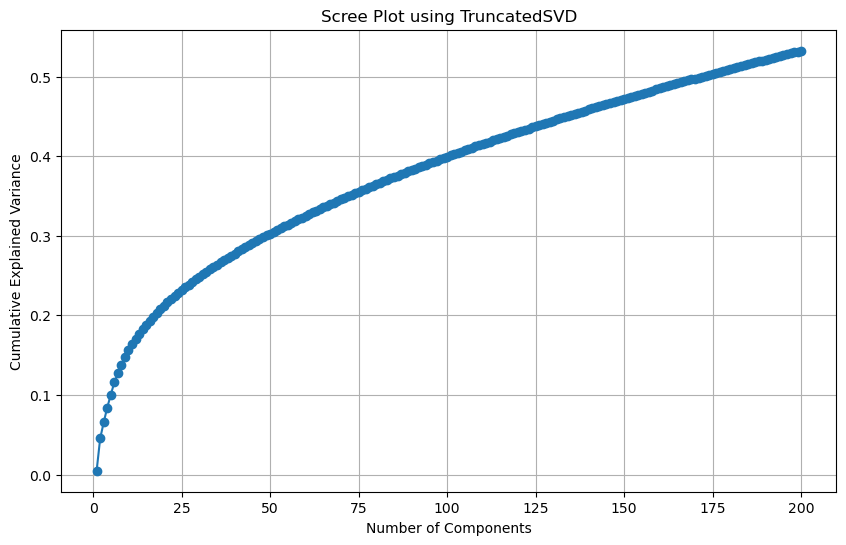

In [77]:
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot using TruncatedSVD')
plt.grid(True)
plt.show()

Processing time is a large condern.  I tried do the rest of the document with 500 and even 200 componets, but roughly 50 componets seems to be approximately the best number while still holding all the data in memory

Here we selected 50 componets mainly due to performance issues. There’s a diminishing returns effect: going from 50 to 100 componets means we go from 30% to 40%.  This is a doubling the number of components, with comes with  significant computational cost.  For this use case we will go with just 50 componets, but ideally we would compare different number of features.  


In [79]:
n_components = 50
print(f"Applying TruncatedSVD with {n_components} components...")
svd = TruncatedSVD(n_components=n_components, random_state=42, n_iter=10)
reduced_data = svd.fit_transform(azdiasv)
print(f"Reduced data shape: {reduced_data.shape}")

Applying TruncatedSVD with 50 components...
Reduced data shape: (817704, 50)


In [ ]:
# Save the SVD model for future use
joblib.dump(svd, 'truncated_svd_model.joblib')

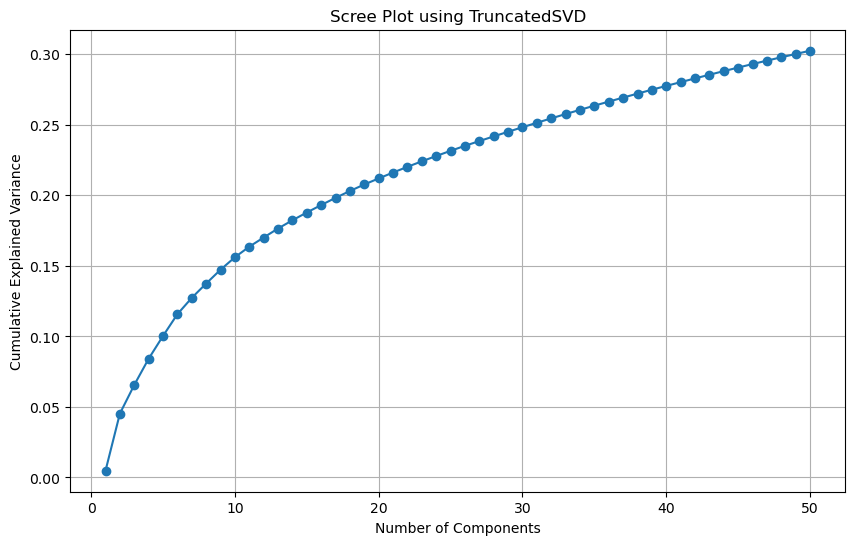

In [80]:
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot using TruncatedSVD')
plt.grid(True)
plt.show()

Below is an interpretation of the graph showing the individual and cumulative explained variance from a Truncated SVD with 1 to 50 componets.

In [81]:
truncatedSVD_scaler = StandardScaler()
scaled_data_SVD = truncatedSVD_scaler.fit_transform(reduced_data)

In [82]:
np.shape(scaled_data_SVD)

(817704, 50)

K=5, Inertia=38564808.0
K=6, Inertia=37612240.0
K=7, Inertia=37356892.0
K=8, Inertia=36745380.0
K=9, Inertia=36445868.0
K=10, Inertia=36030096.0
K=11, Inertia=35849828.0
K=12, Inertia=35775432.0
K=13, Inertia=35423420.0
K=14, Inertia=35438120.0
K=15, Inertia=35492832.0
K=16, Inertia=34402152.0
K=17, Inertia=34018160.0
K=18, Inertia=34016624.0
K=19, Inertia=33758424.0
K=20, Inertia=33690024.0
K=21, Inertia=33603400.0
K=22, Inertia=33362172.0
K=23, Inertia=33285636.0
K=24, Inertia=33348130.0
K=25, Inertia=33285540.0
K=26, Inertia=33046584.0
K=27, Inertia=32932880.0
K=28, Inertia=32638984.0
K=29, Inertia=32772638.0
K=30, Inertia=32483572.0
K=31, Inertia=32613046.0
K=32, Inertia=32699816.0
K=33, Inertia=32403842.0
K=34, Inertia=32314354.0
K=35, Inertia=32421202.0
K=36, Inertia=32283136.0
K=37, Inertia=32282196.0
K=38, Inertia=32100590.0
K=39, Inertia=31991916.0


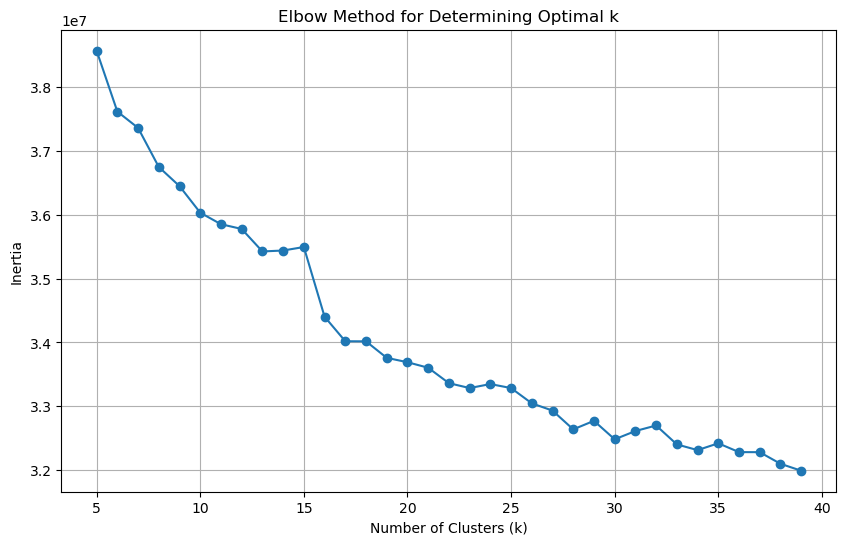

In [83]:
cluster_range = range(5, 40)
inertia = []

for k in cluster_range:
    # I'm using MinibactchkMeans due to the larege dataset, 

    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=50, batch_size=16000)
    kmeans.fit(scaled_data_SVD)  # 'reduced_data' from SVD
    inertia.append(kmeans.inertia_)
    print(f"K={k}, Inertia={kmeans.inertia_}")

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Determining Optimal k')
plt.grid(True)
plt.show()

There is a sharp drop at k=15, so we will proceed with that value.  First we will run some more tests with k=15 and observe the Silhouette score.

In [84]:
sample_size = int(len(scaled_data_SVD) * 0.05)
# Generate random indices
random_indices = np.random.choice(len(scaled_data_SVD), size=sample_size, replace=False)
silhouette_data_sample = scaled_data_SVD[random_indices]

# Define a range of cluster numbers to try
cluster_range = range(10, 20)
inertia = []
silhouette_scores = []

for k in cluster_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=20, batch_size=16000)
    kmeans.fit(scaled_data_SVD)
    cluster_labels =  kmeans.predict(silhouette_data_sample)
    score = silhouette_score(silhouette_data_sample, cluster_labels)
    silhouette_scores.append(score)
    inertia.append(kmeans.inertia_)
    print(f"K={k}, Inertia={kmeans.inertia_}")
    print(f"K={k}, Silhouette Score={score:.4f}")


K=10, Inertia=36434368.0
K=10, Silhouette Score=0.0309
K=11, Inertia=35940400.0
K=11, Silhouette Score=0.0338
K=12, Inertia=35793016.0
K=12, Silhouette Score=0.0352
K=13, Inertia=35557576.0
K=13, Silhouette Score=0.0373
K=14, Inertia=35336788.0
K=14, Silhouette Score=0.0362
K=15, Inertia=34597048.0
K=15, Silhouette Score=0.0440
K=16, Inertia=34410896.0
K=16, Silhouette Score=0.0439
K=17, Inertia=34228600.0
K=17, Silhouette Score=0.0410
K=18, Inertia=33994212.0
K=18, Silhouette Score=0.0420
K=19, Inertia=33809196.0
K=19, Silhouette Score=0.0419


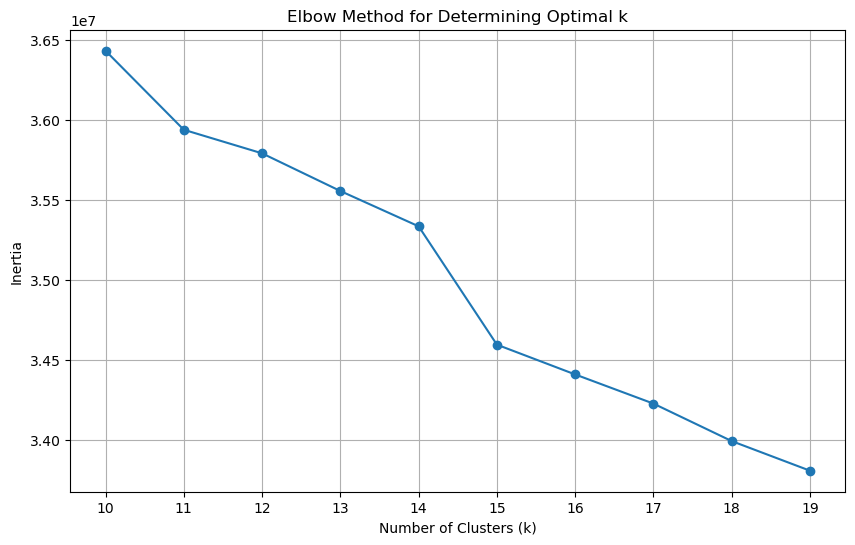

In [85]:
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(min(cluster_range), max(cluster_range) + 1))
plt.title('Elbow Method for Determining Optimal k')
plt.grid(True)
plt.show()

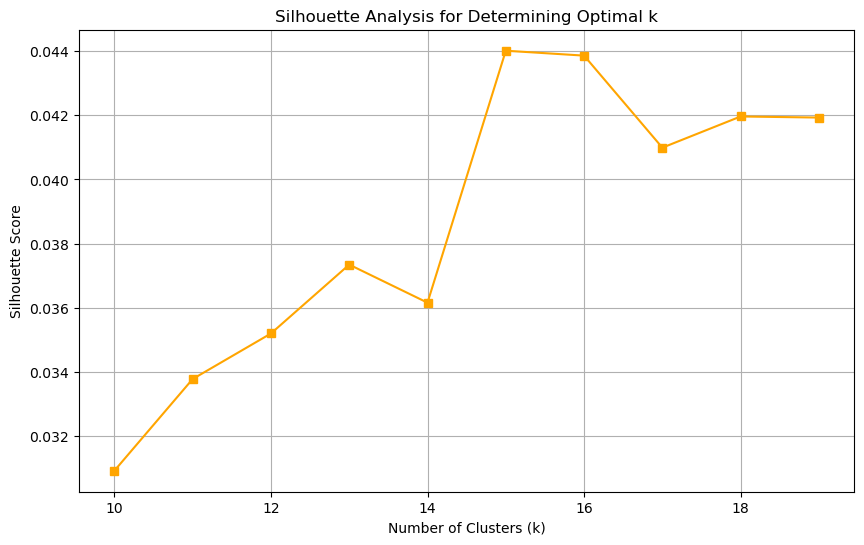

In [86]:
# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='s', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Determining Optimal k')
plt.grid(True)
plt.show()

based on the silhouette and the apparent 'corner' in the inertia plot, it looks like k=15 will be a good clustering score

# Cluster analysis and comparison to customer dataset

We will use standard KMeans. Ideally we would want to use a clustering algorithm like hiearchical, or something that can assume non oval distributions, but becuase we have roughly 1M rows, we will go with KMeans.  Birch Might be a potential option in the future.

In [87]:
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=20, batch_size=16000)
kmeans.fit(scaled_data_SVD)
cluster_labels =  kmeans.predict(scaled_data_SVD)

In [88]:
print(f"SVD Components: {svd.components_.shape}")  # Should be (n_components, n_original_features)
print(f"Scaled Centers Shape: {kmeans.cluster_centers_.shape}")  # Should be (n_clusters, n_components)

SVD Components: (50, 2394)
Scaled Centers Shape: (19, 50)


In [89]:
# Invert scaling
unscaled_centers = truncatedSVD_scaler.inverse_transform(kmeans.cluster_centers_)

In [90]:
unscaled_centers_detransformed = svd.inverse_transform(unscaled_centers)

In [91]:
azdias_centers_svd_space = kmeans.cluster_centers_  # shape = (11, 30)

In [92]:
azdias['cluster'] = cluster_labels

In [93]:
cluster_stats_azdias = azdias.groupby('cluster').describe()

Cluster Size Distribution:
0     35867
1     44683
2     48635
3     41114
4     37936
5     39846
6     52789
7     32757
8     65296
9     66711
10    25802
11    42736
12    23734
13    17697
14    66055
15    32223
16    49477
17    32322
18    62024
Name: count, dtype: int64


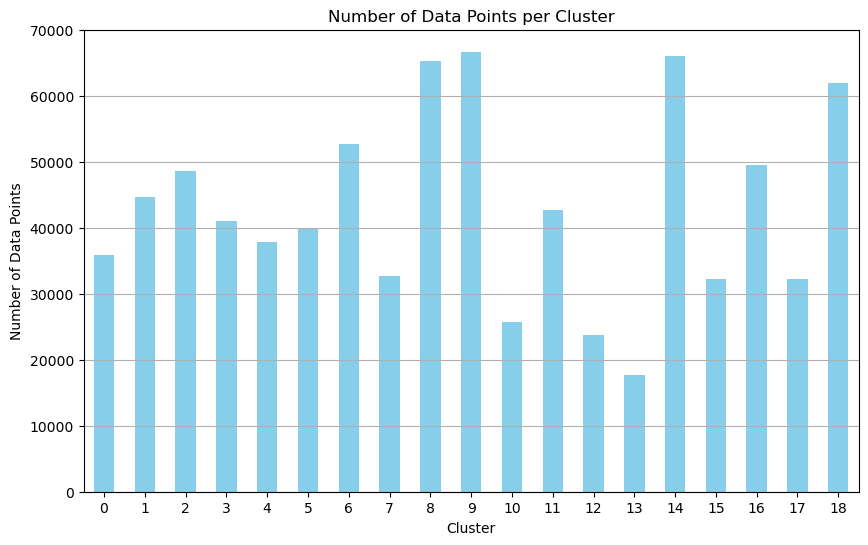

In [94]:
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()

print("Cluster Size Distribution:")
print(cluster_counts)

plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points per Cluster')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [95]:
cluster_centers_scaled_back = truncatedSVD_scaler.inverse_transform(kmeans.cluster_centers_)

## PCA

Establishing a Baseline (General Population):
The main goal is to understand how the customer base differs from the broader German population. To do that, you first want to identify the underlying structure of the general population on its own. The AZDIAS dataset represents the general population, and performing PCA on this dataset alone allows you to find principal components that describe the natural variance and structure within Germany’s overall demographics.

Projecting Customers onto the Population Baseline:
Once you have the principal components derived solely from the AZDIAS data, you can then project the customer data onto that same PCA space. This way, you’re looking at how customers fit into (or deviate from) the existing population structure. If you were to combine customers and the population before PCA, the principal components might shift to emphasize the difference between the two groups, which can obscure your ability to identify how customers uniquely position themselves relative to the general population baseline.

Comparability and Interpretability:
By using the population-derived components, you can say: “Here’s how the general population distributes along these axes of variation (derived without bias from the customers), and here’s where the customers land on these same axes.” This approach makes the interpretation of differences more straightforward and meaningful. You’re essentially asking: Where do the customers sit within the existing landscape of the population’s demographics?

In [96]:
# Further reduce to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
visual_data = pca.fit_transform(scaled_data_SVD)

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


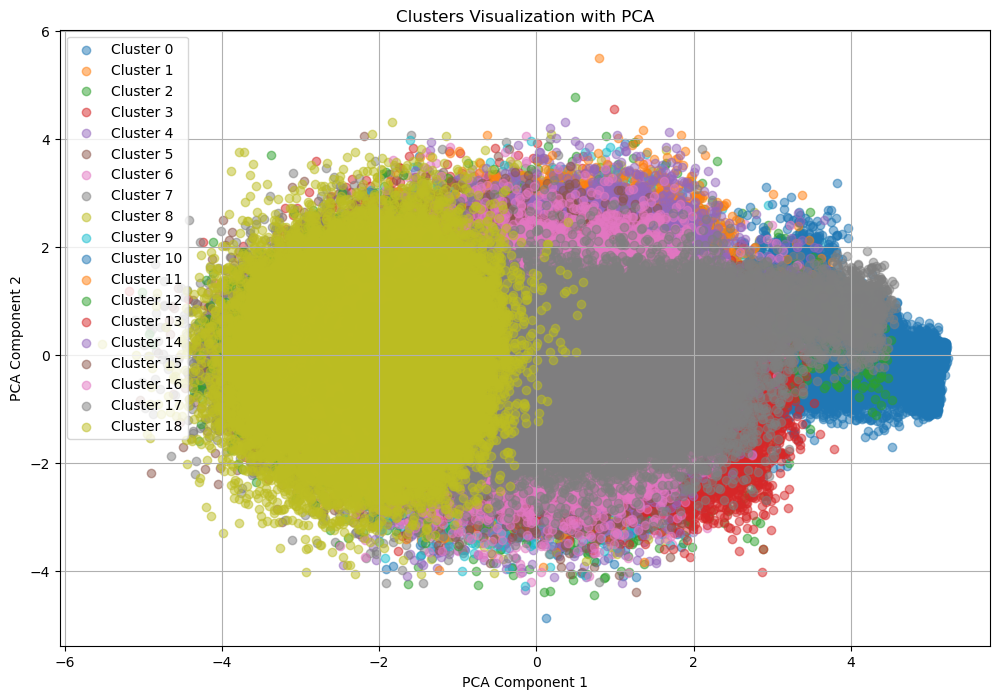

In [99]:
plt.figure(figsize=(12,8))
for cl in np.unique(cluster_labels):
    mask = (cluster_labels == cl)
    plt.scatter(
        visual_data[mask, 0],
        visual_data[mask, 1],
        label=f"Cluster {cl}",
        alpha=0.5
    )

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualization with PCA')
plt.legend()
plt.grid(True)
plt.show()

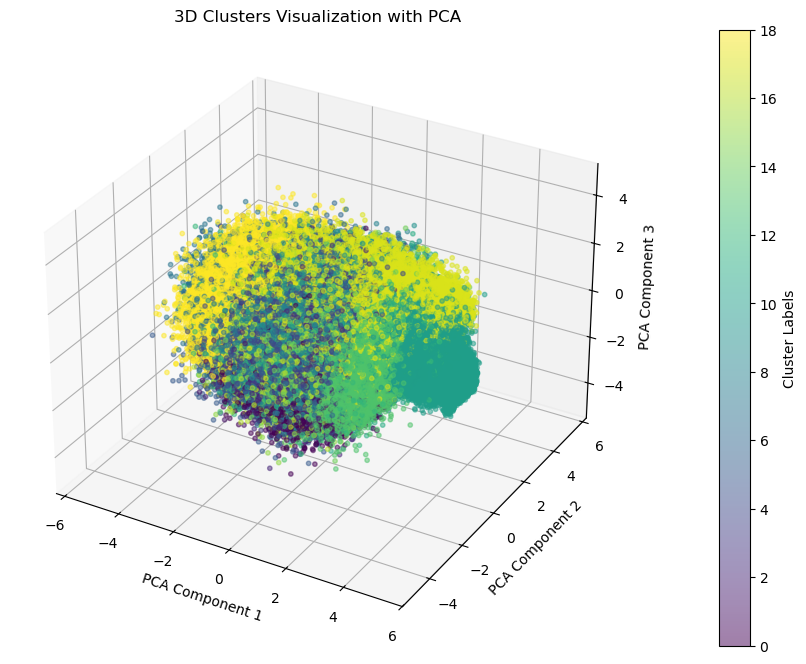

In [100]:
# Reduce the data to 3 components
pca_3d = PCA(n_components=3, random_state=42)
visual_data_3d = pca_3d.fit_transform(scaled_data_SVD)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    visual_data_3d[:, 0],
    visual_data_3d[:, 1],
    visual_data_3d[:, 2],
    c=cluster_labels,      # color by cluster
    cmap='viridis',        # or another colormap
    alpha=0.5,
    s=10                   # marker size
)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Clusters Visualization with PCA')
#  Note: the color bar is not discrete, but this is just a sample visualization so i won't bother
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster Labels')
plt.show()

In [ ]:
cluster_centers_svd_space = kmeans.cluster_centers_  # shape = (11, 30)


Lets compare this headmap to the customer dataset

# Transform and compare to customer dataset

In [103]:
customersv = customers.values
# Convert the dataset to the reduced feature space
customer_svd_data = svd.transform(customersv)

/tmp/ipykernel_28625/150878399.py:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  customersv = customers.values


In [104]:
# Apply the same scaling
customer_scaled_data = truncatedSVD_scaler.transform(customer_svd_data)
# Predict cluster labels
customer_cluster_labels = kmeans.predict(customer_scaled_data)

In [105]:
customers['cluster'] = customer_cluster_labels

In [106]:
azdias_clusters_df = pd.Series(cluster_labels, name='cluster')
customers_clusters_df = pd.Series(customer_cluster_labels, name='cluster')

azdias_dist = azdias_clusters_df.value_counts(normalize=True).sort_index()
customers_dist = customers_clusters_df.value_counts(normalize=True).sort_index()

comparison_df = pd.DataFrame({
    'Azdias_Fraction': azdias_dist,
    'Customers_Fraction': customers_dist
})

print(comparison_df)

         Azdias_Fraction  Customers_Fraction
cluster                                     
0               0.043863            0.023688
1               0.054644            0.019069
2               0.059478            0.040289
3               0.050280            0.026618
4               0.046393            0.043357
5               0.048729            0.039138
6               0.064558            0.055718
7               0.040060            0.114456
8               0.079853            0.012368
9               0.081583            0.250469
10              0.031554            0.025777
11              0.052263            0.021213
12              0.029025            0.041254
13              0.021642            0.010968
14              0.080781            0.111105
15              0.039407            0.011175
16              0.060507            0.006136
17              0.039528            0.032271
18              0.075851            0.114931


This time we need to manually compute the cluster centroids for the customers

In [107]:
n_clusters = kmeans.n_clusters 
n_components = customer_scaled_data.shape[1] 

# Initialize an array for customer-based "centers"
customer_cluster_centers = np.zeros((n_clusters, n_components))

for c in range(n_clusters):
    # Boolean mask for all rows belonging to cluster c
    mask = (customer_cluster_labels == c)
    # If a cluster has no members in the customer dataset, handle that
    if mask.sum() > 0:
        customer_cluster_centers[c, :] = customer_scaled_data[mask].mean(axis=0)
    else:
        # If no customers in that cluster, you can leave it as zeros or handle differently
        customer_cluster_centers[c, :] = np.nan

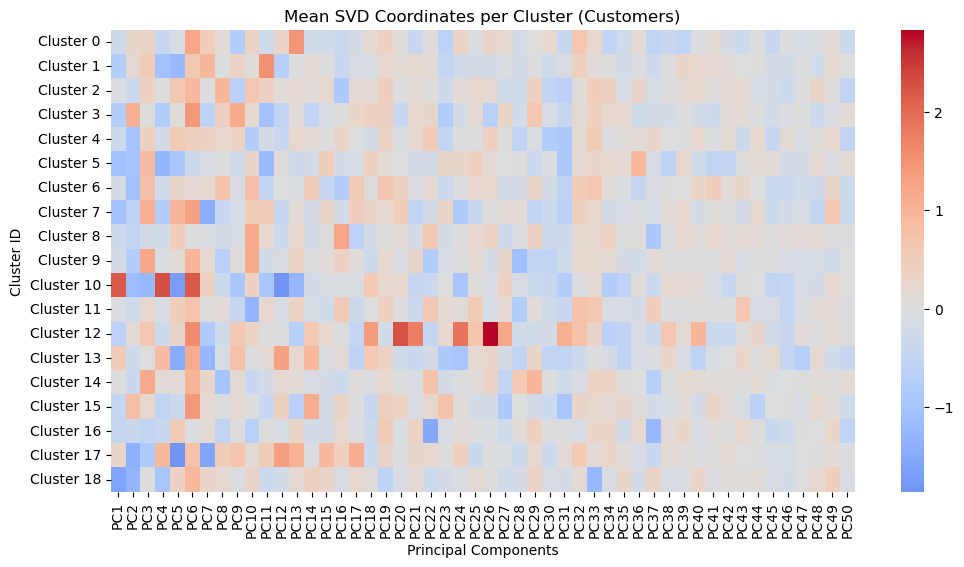

In [108]:

plt.figure(figsize=(12, 6))
sns.heatmap(
    customer_cluster_centers,
    cmap="coolwarm",
    center=0,
    xticklabels=[f"PC{i}" for i in range(1, n_components+1)],
    yticklabels=[f"Cluster {i}" for i in range(n_clusters)]
)
plt.xlabel("Principal Components")
plt.ylabel("Cluster ID")
plt.title("Mean SVD Coordinates per Cluster (Customers)")
plt.show()


We can take the absolute difference of cluster centers to find where the cluster componets tend to very the most.  

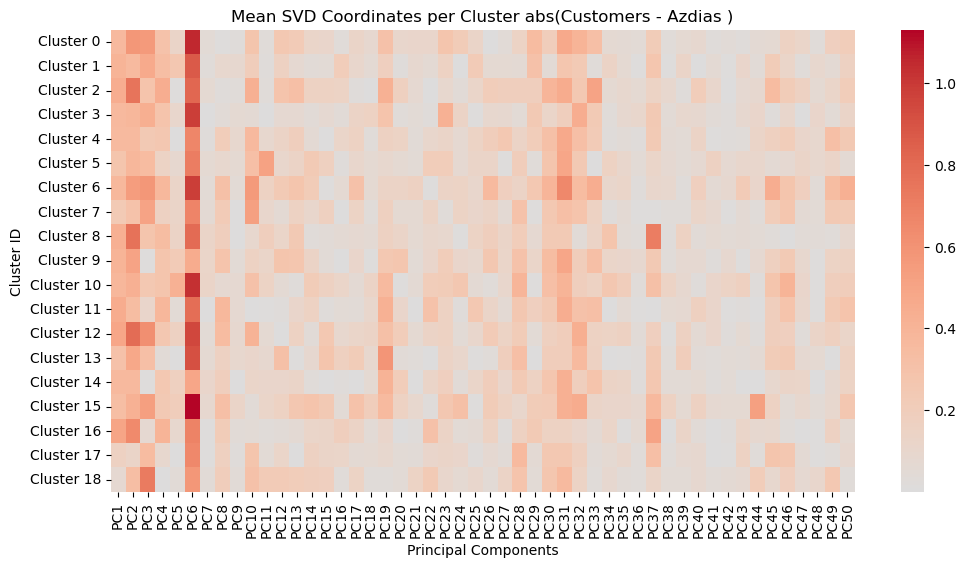

In [109]:
abs_difference = np.abs(customer_cluster_centers - azdias_centers_svd_space)

plt.figure(figsize=(12, 6))
sns.heatmap(
    abs_difference,
    cmap="coolwarm",
    center=0,
    xticklabels=[f"PC{i}" for i in range(1, n_components+1)],
    yticklabels=[f"Cluster {i}" for i in range(n_clusters)]
)
plt.xlabel("Principal Components")
plt.ylabel("Cluster ID")
plt.title("Mean SVD Coordinates per Cluster abs(Customers - Azdias )")
plt.show()

Principle componet 6 (index 5) seems to have the largest difference between the datasets.  We can further explore the PC6

In [110]:
component_id = 5
loadings = svd.components_[component_id]

# Sort features by absolute loading (the higher the absolute value, the more it contributes)
top_features_idx = np.argsort(np.abs(loadings))[::-1][:10]

print(f"Top 10 features for Component {component_id}:")
for idx in top_features_idx:
    feature_name = azdias.columns[idx]  # or your original DataFrame columns
    print(f"Feature: {feature_name}, Loading: {loadings[idx]}")

Top 10 features for Component 5:
Feature: KOMBIALTER_4, Loading: 0.12343952804803848
Feature: FINANZ_VORSORGER_5, Loading: 0.11803735047578812
Feature: FINANZ_ANLEGER_1, Loading: 0.11389028280973434
Feature: FINANZ_SPARER_1, Loading: 0.11317010223865509
Feature: STRUKTURTYP_3, Loading: 0.10049422830343246
Feature: ANZ_HAUSHALTE_AKTIV, Loading: 0.09561221301555634
Feature: ALTERSKATEGORIE_GROB_4, Loading: 0.09384339302778244
Feature: D19_KONSUMTYP_9, Loading: -0.09308956563472748
Feature: D19_GESAMT_ANZ_24_0, Loading: -0.09090888500213623
Feature: D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT, Loading: -0.09011524170637131


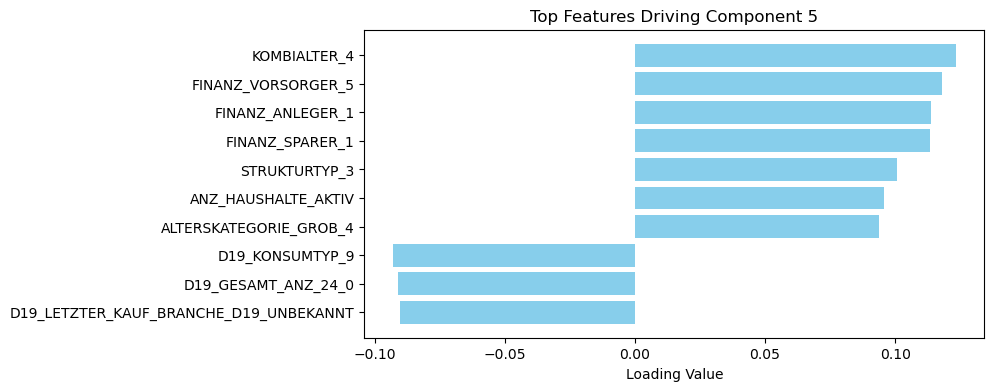

In [111]:
top_feature_names = azdias.columns[top_features_idx]
top_feature_loadings = loadings[top_features_idx]

plt.figure(figsize=(8, 4))
plt.barh(top_feature_names, top_feature_loadings, color='skyblue')
plt.gca().invert_yaxis()  # so the top feature is at the top
plt.xlabel("Loading Value")
plt.title(f"Top Features Driving Component {component_id}")
plt.show()

The feature "KOMBIALTER"  isn't described in the Attribute values, or Information levels attributes files, so we cannot make any good assesments about this feature.  We can see it is a binary item, but aside from that there isn't much more information

In [112]:
customers['KOMBIALTER_4'].unique()

[True, False]
Fill: False
IntIndex
Indices: array([0], dtype=int32)

The other top features include 


- FINANZ_VORSORGER: Financial typology - "Be prepared"
- FINANZ_ANLEGER: Financial typology - "Investor"
- FINANZ_SPARER: Financial typology - "Money saver"
- HAUSHALTSSTRUKTUR: Structure of the household (e.g., single household, couple with different surnames, family, etc.)
- ANZ_HAUSHALTE_AKTIV: Number of households known in this building
- ALTERSKATEGORIE_GROB: Age classification through prename analysis

with STRUKTURTYP not being mentioned in file description


So in general it looks like 

. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [113]:
features = [
    "KOMBIALTER_4",
    "FINANZ_VORSORGER_5",
    "FINANZ_ANLEGER_1",
    "FINANZ_SPARER_1",
    "STRUKTURTYP_3",
    "ANZ_HAUSHALTE_AKTIV",
    "ALTERSKATEGORIE_GROB_4",
    "D19_KONSUMTYP_9",
    "D19_GESAMT_ANZ_24_0",
    "D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT"
]

# Dictionaries to store the results for each DataFrame
customers_means = {}
customers_stds = {}
azdias_means = {}
azdias_stds = {}



In [139]:
def process_column(df, feature):
    """
    Processes a single column to compute mean, std, and count.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the column.
    - feature (str): The column name to process.
    
    Returns:
    - mean (float): Mean of the column.
    - std (float): Standard deviation of the column.
    - count (int): Number of non-NaN observations.
    """
    col = df[feature]
    
    # Check if the column is sparse using the updated method
    if isinstance(col.dtype, pd.SparseDtype):
        # Convert sparse column to dense
        col_data = col.sparse.to_dense()
    else:
        col_data = col.copy()
    
    # If the column is of boolean type, convert to integer
    if col_data.dtype == bool:
        col_data = col_data.astype(int)
    else:
        # Ensure the column is numeric; convert if necessary
        col_data = pd.to_numeric(col_data, errors='coerce')
    
    # Drop NaN values
    col_data = col_data.dropna()
    
    # Compute mean and std, ignoring NaN values
    mean = col_data.mean()
    std = col_data.std()
    count = col_data.count()
    
    return mean, std, count

Next we will calculate the STD and means for the customers and azdias

In [140]:
for feature in features:
    try:
        mean, std,_ = process_column(customers, feature)
        customers_means[feature] = mean
        customers_stds[feature] = std
        print(f"Customers - {feature}: Mean = {mean}, Std = {std}")
    except Exception as e:
        print(f"Error processing feature '{feature}' in 'customers' DataFrame: {e}")

Customers - KOMBIALTER_4: Mean = 0.7526611146347517, Std = 0.4314668522360268
Customers - FINANZ_VORSORGER_5: Mean = 0.7189283843035601, Std = 0.44952392110426503
Customers - FINANZ_ANLEGER_1: Mean = 0.6510492788792984, Std = 0.4766399915934072
Customers - FINANZ_SPARER_1: Mean = 0.7255053360174283, Std = 0.4462608165352665
Customers - STRUKTURTYP_3: Mean = 0.7155227090974271, Std = 0.45116667115664916
Customers - ANZ_HAUSHALTE_AKTIV: Mean = -0.4349636435508728, Std = 0.8830279111862183
Customers - ALTERSKATEGORIE_GROB_4: Mean = 0.5917257259465571, Std = 0.4915160798252827
Customers - D19_KONSUMTYP_9: Mean = 0.09384910239086672, Std = 0.291619674675478
Customers - D19_GESAMT_ANZ_24_0: Mean = 0.31107464909136034, Std = 0.4629348650135995
Customers - D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT: Mean = 0.2275528775887268, Std = 0.41925383395764854


In [141]:
for feature in features:
    try:
        mean, std, _ = process_column(azdias, feature)
        azdias_means[feature] = mean
        azdias_stds[feature] = std
        print(f"Azdias - {feature}: Mean = {mean}, Std = {std}")
    except Exception as e:
        print(f"Error processing feature '{feature}' in 'azdias' DataFrame: {e}")

Azdias - KOMBIALTER_4: Mean = 0.3335730288710829, Std = 0.4714894857178428
Azdias - FINANZ_VORSORGER_5: Mean = 0.2962636846585072, Std = 0.45660898894267143
Azdias - FINANZ_ANLEGER_1: Mean = 0.2578072260867013, Std = 0.4374275874523408
Azdias - FINANZ_SPARER_1: Mean = 0.30598725211078825, Std = 0.4608246015116976
Azdias - STRUKTURTYP_3: Mean = 0.7086549656110279, Std = 0.454382391623421
Azdias - ANZ_HAUSHALTE_AKTIV: Mean = 0.06956962496042252, Std = 0.9872426986694336
Azdias - ALTERSKATEGORIE_GROB_4: Mean = 0.27944586305068825, Std = 0.4487272210600499
Azdias - D19_KONSUMTYP_9: Mean = 0.5355140735522879, Std = 0.498737460766455
Azdias - D19_GESAMT_ANZ_24_0: Mean = 0.5280468237895375, Std = 0.49921306117508985
Azdias - D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT: Mean = 0.4634121882735073, Std = 0.49865984010188463


In [142]:
print("\nCustomers Means:", customers_means)
print("Customers Stds:", customers_stds)
print("Azdias Means:", azdias_means)
print("Azdias Stds:", azdias_stds)


Customers Means: {'KOMBIALTER_4': 0.7526611146347517, 'FINANZ_VORSORGER_5': 0.7189283843035601, 'FINANZ_ANLEGER_1': 0.6510492788792984, 'FINANZ_SPARER_1': 0.7255053360174283, 'STRUKTURTYP_3': 0.7155227090974271, 'ANZ_HAUSHALTE_AKTIV': -0.43496364, 'ALTERSKATEGORIE_GROB_4': 0.5917257259465571, 'D19_KONSUMTYP_9': 0.09384910239086672, 'D19_GESAMT_ANZ_24_0': 0.31107464909136034, 'D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT': 0.2275528775887268}
Customers Stds: {'KOMBIALTER_4': 0.4314668522360268, 'FINANZ_VORSORGER_5': 0.44952392110426503, 'FINANZ_ANLEGER_1': 0.4766399915934072, 'FINANZ_SPARER_1': 0.4462608165352665, 'STRUKTURTYP_3': 0.45116667115664916, 'ANZ_HAUSHALTE_AKTIV': 0.8830279, 'ALTERSKATEGORIE_GROB_4': 0.4915160798252827, 'D19_KONSUMTYP_9': 0.291619674675478, 'D19_GESAMT_ANZ_24_0': 0.4629348650135995, 'D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT': 0.41925383395764854}
Azdias Means: {'KOMBIALTER_4': 0.3335730288710829, 'FINANZ_VORSORGER_5': 0.2962636846585072, 'FINANZ_ANLEGER_1': 0.2578072

In [146]:
from math import sqrt
from scipy.stats import t

def welch_ttest_from_summary(mean1, std1, n1, mean2, std2, n2):
    """
    Compute Welch's t-test from summary stats:
    (mean, std, count) for each group.
    
    Returns:
    - t_stat (float): Welch's t-statistic
    - df (float): Degrees of freedom (Welch–Satterthwaite)
    - p_value (float): Two-sided p-value
    """
    # t-statistic
    numerator = mean1 - mean2
    denominator = sqrt((std1**2 / n1) + (std2**2 / n2))
    t_stat = numerator / denominator
    
    # Welch–Satterthwaite degrees of freedom
    df_num = ((std1**2 / n1) + (std2**2 / n2))**2
    df_den = ((std1**2 / n1)**2) / (n1 - 1) + ((std2**2 / n2)**2) / (n2 - 1)
    df = df_num / df_den
    
    # Two-sided p-value
    # survival function (1 - cdf)
    p_value = 2 * (1 - t.cdf(abs(t_stat), df))
    
    return t_stat, df, p_value

In [144]:
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

# Initialize lists to store results
z_stats = []
p_values = []
cohen_ds = []

for feature in features:
    # Process the 'customers' data
    mean1, std1, count1 = process_column(customers, feature)
    
    # Process the 'azdias' data
    mean2, std2, count2 = process_column(azdias, feature)
    
    # Calculate the standard error (SE) for the difference in means
    se = np.sqrt((std1 ** 2) / count1 + (std2 ** 2) / count2)
    
    # Calculate the Z-statistic
    z = (mean1 - mean2) / se
    z_stats.append(z)
    
    # Calculate the two-tailed p-value
    p = 2 * (1 - norm.cdf(abs(z)))
    p_values.append(p)
    
    # Calculate Cohen's d (Effect Size)
    pooled_std = np.sqrt(((std1 ** 2) + (std2 ** 2)) / 2)
    if pooled_std == 0:
        d = np.nan
    else:
        d = (mean1 - mean2) / pooled_std
    cohen_ds.append(d)

# Create a results DataFrame
results_df = pd.DataFrame({
    'Feature': features,
    'Customers Mean': [process_column(customers, feat)[0] for feat in features],
    'Customers Std': [process_column(customers, feat)[1] for feat in features],
    'Azdias Mean': [process_column(azdias, feat)[0] for feat in features],
    'Azdias Std': [process_column(azdias, feat)[1] for feat in features],
    'Z-Statistic': z_stats,
    'P-Value': p_values,
    'Cohen\'s d': cohen_ds
})


In [145]:
results_df

,Feature,Customers Mean,Customers Std,Azdias Mean,Azdias Std,Z-Statistic,P-Value,Cohen's d
0,KOMBIALTER_4,0.752661,0.431467,0.333573,0.471489,336.046847,0.000000e+00,0.927347
1,FINANZ_VORSORGER_5,0.718928,0.449524,0.296264,0.456609,329.236543,0.000000e+00,0.932869
2,FINANZ_ANLEGER_1,0.651049,0.476640,0.257807,0.437428,293.086082,0.000000e+00,0.859632
3,FINANZ_SPARER_1,0.725505,0.446261,0.305987,0.460825,328.325243,0.000000e+00,0.924861
4,STRUKTURTYP_3,0.715523,0.451167,0.708655,0.454382,5.337174,9.440664e-08,0.015168
5,ANZ_HAUSHALTE_AKTIV,-0.434964,0.883028,0.069570,0.987243,-196.874489,0.000000e+00,-0.538694
6,ALTERSKATEGORIE_GROB_4,0.591726,0.491516,0.279446,0.448727,225.852978,0.000000e+00,0.663567
7,D19_KONSUMTYP_9,0.093849,0.291620,0.535514,0.498737,-468.038110,0.000000e+00,-1.081128
8,D19_GESAMT_ANZ_24_0,0.311075,0.462935,0.528047,0.499213,-162.525582,0.000000e+00,-0.450696
9,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,0.227553,0.419254,0.463412,0.498660,-191.565968,0.000000e+00,-0.511991


### Analizing the results

The above table indicates that there are significant and meaningful differences between the Customers and Azdias groups across most features.

These differences vary in magnitude. Diving deeper and understanding these distinctions can be crucial for targeted strategies, marketing, product development, or other business decisions based on the characteristics that differentiate Customers from Azdias.

The exception is STRUKTURTYP_3, which, despite being statistically significant, has a negligible effect size, indicating that the difference between the groups for this feature is practically insignificant..

Most features have large to medium effect sizes, suggesting that the differences are not only statistically significant but also practically meaningful.
The exception is STRUKTURTYP_3, which, despite being statistically significant, has a negligible effect size, indicating that the difference between the groups for this feature is practically insignificant.
